# Importing libraries

In [2]:
# import pyspark.sql module
from pyspark.sql import SparkSession

# Create SparkSession object
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('Spark Application') \
                    .getOrCreate()

# Importing Data

In [3]:
# import data
df = spark.read.csv('./data/creditcard.csv',
                         sep=',',
                         header=True)

# View the first five records
df.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [4]:
# Get number of records
print("The data contain %d records." % df.count())

The data contain 6362620 records.


In [5]:
# Get number of columns
print("The data contain %d columns." % len(df.columns))

The data contain 11 columns.


In [6]:
# Select randomly 1M records
df = df.sample(False, 0.157, 42)

# Data Pre-processing 

In [7]:
### Get count of nan or missing values
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



### Observations:

This dataset is clean, no missing values.

In [8]:
# Schema of the data
df.printSchema()

root
 |-- step: string (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: string (nullable = true)
 |-- newbalanceOrig: string (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: string (nullable = true)
 |-- newbalanceDest: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- isFlaggedFraud: string (nullable = true)



In [9]:
from pyspark.sql.types import DoubleType

df = df.withColumn("step", df.step.cast(DoubleType()))
df = df.withColumn("amount", df.amount.cast(DoubleType()))
df = df.withColumn("oldbalanceOrg", df.oldbalanceOrg.cast(DoubleType()))
df = df.withColumn("newbalanceOrig", df.newbalanceOrig.cast(DoubleType()))
df = df.withColumn("oldbalanceDest", df.oldbalanceDest.cast(DoubleType()))
df = df.withColumn("newbalanceDest", df.newbalanceDest.cast(DoubleType()))
df = df.withColumn("isFraud", df.isFraud.cast('int'))

In [10]:
# Check column data types
df.dtypes

[('step', 'double'),
 ('type', 'string'),
 ('amount', 'double'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'double'),
 ('newbalanceDest', 'double'),
 ('isFraud', 'int'),
 ('isFlaggedFraud', 'string')]

In [11]:
df = df.drop('isFlaggedFraud')

In [12]:
# Input variables : step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest
# Output Variable : isFraud

# EDA : Feature Engineering 

In [13]:
df.describe().show()

+-------+------------------+--------+-----------------+-----------+-----------------+-----------------+-----------+-----------------+------------------+--------------------+
|summary|              step|    type|           amount|   nameOrig|    oldbalanceOrg|   newbalanceOrig|   nameDest|   oldbalanceDest|    newbalanceDest|             isFraud|
+-------+------------------+--------+-----------------+-----------+-----------------+-----------------+-----------+-----------------+------------------+--------------------+
|  count|           1000080| 1000080|          1000080|    1000080|          1000080|          1000080|    1000080|          1000080|           1000080|             1000080|
|   mean|243.25682345412366|    null|180017.5484425851|       null|833290.2638769192|854371.0914694715|       null|1109166.698026399|1234249.1053278393|0.001265898728101752|
| stddev|142.32584821218623|    null|593383.8581626411|       null|2894588.332097965|2929964.784413958|       null|3497349.6724989

In [14]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'double' or t[1]=='int']
df.select(numeric_features).describe().toPandas()

,summary,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,count,1000080,1000080,1000080,1000080,1000080,1000080,1000080
1,mean,243.25682345412366,180017.5484425851,833290.2638769192,854371.0914694715,1109166.698026399,1234249.1053278393,0.001265898728101752
2,stddev,142.32584821218623,593383.8581626411,2894588.332097965,2929964.784413958,3497349.672498992,3771873.894500269,0.03555696124120139
3,min,1.0,0.0,0.0,0.0,0.0,0.0,0
4,max,743.0,7.382349036E7,5.958504037E7,4.958504037E7,3.5538143361E8,3.555534163E8,1


In [15]:
df.groupBy("isFraud").count().show()

+-------+------+
|isFraud| count|
+-------+------+
|      1|  1266|
|      0|998814|
+-------+------+



In [16]:
import seaborn as sns
from matplotlib import pyplot as plt
pd_df = df.toPandas()
print('Distribution of the Classes in the dataset')
print(pd_df['isFraud'].value_counts()/len(pd_df))

Distribution of the Classes in the dataset
0    0.998734
1    0.001266
Name: isFraud, dtype: float64


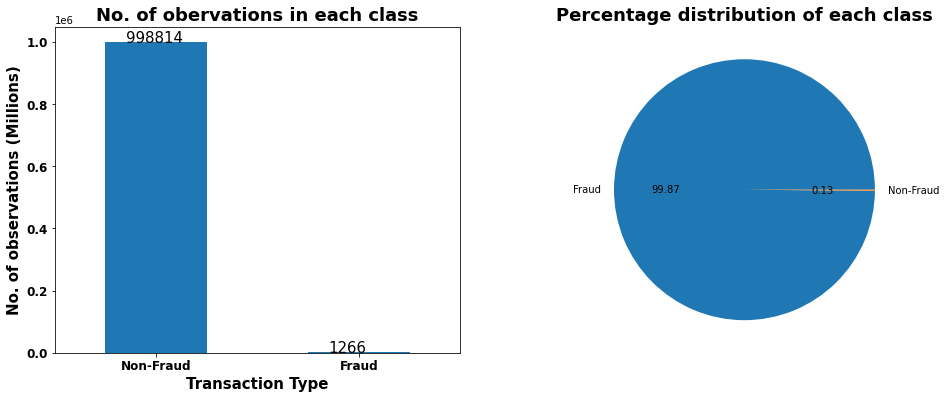

In [17]:
# fraudulent transactions
plt.subplots(1,2, figsize=(16,6))

# countplot to visualize the no. of observations under each class
plt.subplot(1,2,1)
ax = pd_df['isFraud'].value_counts().plot(kind='bar')
plt.xlabel('Transaction Type', fontsize=15, fontweight='bold')
plt.xticks(ticks=[0,1], labels=['Non-Fraud','Fraud'], rotation=0, fontsize=12, fontweight='bold')
plt.ylabel('No. of observations (Millions)', fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('No. of obervations in each class', fontsize=18, fontweight='bold')
for i in ax.patches:
    ax.text(i.get_x()+0.1, i.get_height()+3, str(round(i.get_height(), 2)), fontsize=15, color='black')

# pie chart to visualize the percentage distribution of each class
plt.subplot(1,2,2)
plt.pie(pd_df['isFraud'].value_counts(), labels=['Fraud','Non-Fraud'], autopct='%.2f')
plt.title('Percentage distribution of each class', fontsize=18, fontweight='bold')

# display plot
plt.show()

### Observations:

Fraudulent transaction observations are only 8,213 (0.13%). Fraud is rare.

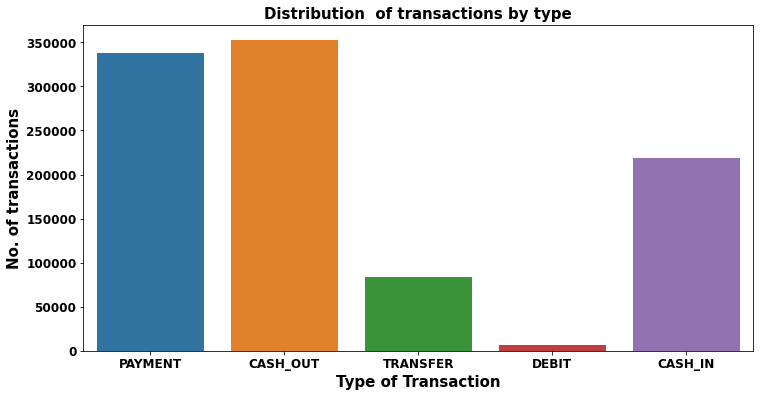

In [18]:
plt.subplots(figsize=(12,6))
sns.countplot('type', data=pd_df)
plt.xlabel('Type of Transaction', fontsize=15, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel('No. of transactions', fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('Distribution  of transactions by type', fontsize=15, fontweight='bold')
plt.show()

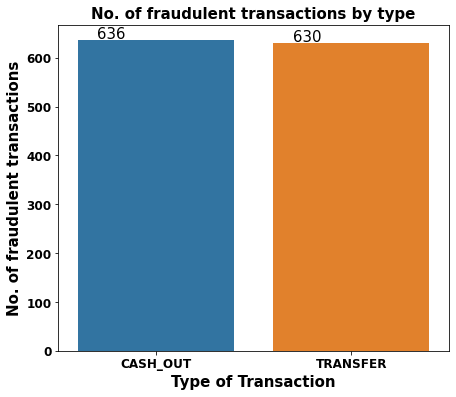

In [19]:
plt.subplots(figsize=(7,6))
fr_df = pd_df[pd_df['isFraud'] == 1]
ax =sns.countplot('type', data=fr_df)
for i in ax.patches:
    ax.text(i.get_x()+0.1, i.get_height()+3, str(round(i.get_height(), 2)), fontsize=15, color='black')
plt.xlabel('Type of Transaction', fontsize=15, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel('No. of fraudulent transactions', fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('No. of fraudulent transactions by type', fontsize=15, fontweight='bold')
plt.show()

In [20]:
print(fr_df['type'].value_counts()/len(fr_df))

CASH_OUT    0.50237
TRANSFER    0.49763
Name: type, dtype: float64


Nous pouvons observer que les transactions frauduleuses sont uniquement des retraits (cash_out) et des virements (transfer) avec des taux de fraude de 0.5% pour chacun d'entre eux.

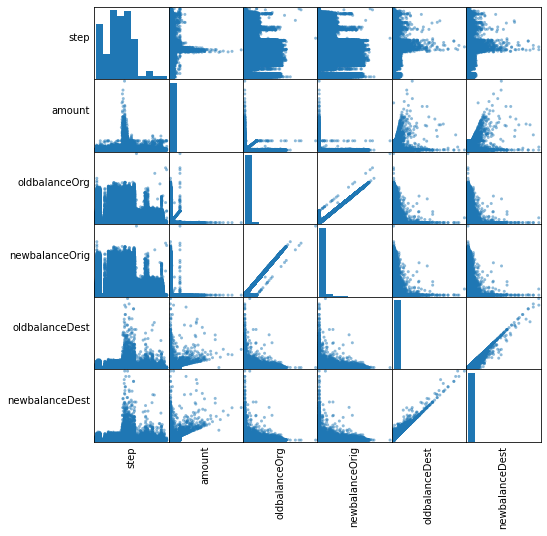

In [21]:
import pandas as pd
from pandas.plotting import scatter_matrix

numeric_features = ['step', 'amount', 'oldbalanceOrg',
                    'newbalanceOrig','oldbalanceDest', 
                    'newbalanceDest']

numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

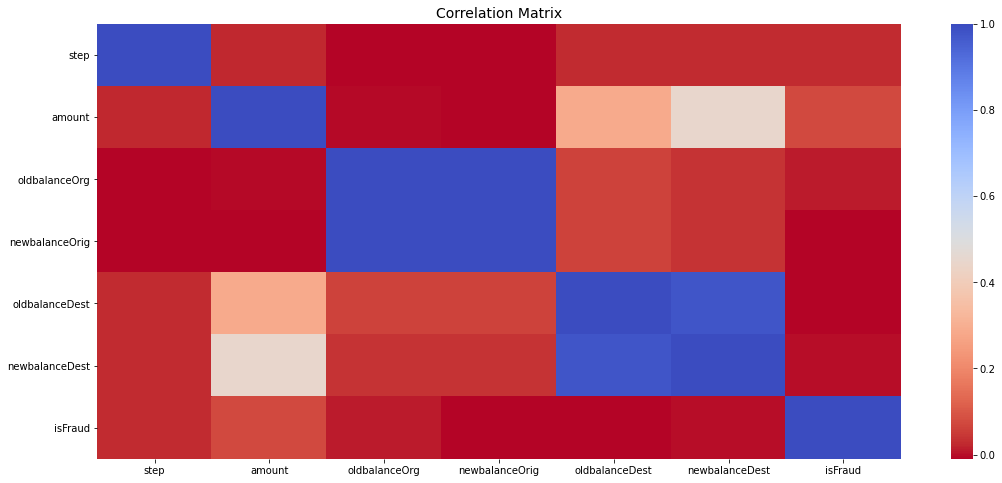

In [23]:
# we can check the important parameters that could effect our model.
f, ax = plt.subplots(figsize=(18,8))

sub_sample_corr = pd_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax)
ax.set_title('Correlation Matrix', fontsize=14)
plt.show()

Il n'y a pas de corrélations visibles entre les variables.

# Data Pre-processing :

In [136]:
data = df

In [138]:
data.show(5)

+----+--------+-------+-----------+-------------+--------------+-----------+--------------+--------------+-------+
|step|    type| amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|
+----+--------+-------+-----------+-------------+--------------+-----------+--------------+--------------+-------+
| 1.0| PAYMENT|7861.64|C1912850431|    176087.23|     168225.59| M633326333|           0.0|           0.0|      0|
| 1.0| PAYMENT|1563.82| C761750706|        450.0|           0.0|M1731217984|           0.0|           0.0|      0|
| 1.0| PAYMENT| 671.64|C2033524545|      15123.0|      14451.36| M473053293|           0.0|           0.0|      0|
| 1.0|CASH_OUT|5346.89| C512549200|          0.0|           0.0| C248609774|      652637.0|    6453430.91|      0|
| 1.0| PAYMENT|2641.47| C460570271|      23053.0|      20411.53|M1653361344|           0.0|           0.0|      0|
+----+--------+-------+-----------+-------------+--------------+-----------+----

In [139]:
data['type', 'nameOrig', 'nameDest'].show(5)

+--------+-----------+-----------+
|    type|   nameOrig|   nameDest|
+--------+-----------+-----------+
| PAYMENT|C1912850431| M633326333|
| PAYMENT| C761750706|M1731217984|
| PAYMENT|C2033524545| M473053293|
|CASH_OUT| C512549200| C248609774|
| PAYMENT| C460570271|M1653361344|
+--------+-----------+-----------+
only showing top 5 rows



## separate nameOrig and nameDest :

In [140]:
import pyspark.sql.functions as F

data = (
    data.withColumn('str_orig', substring('nameOrig', 1,1))
    .withColumn('num_orig', F.col('nameOrig').substr(F.lit(2), F.length('nameOrig') - F.lit(1)))
)
data = data.drop('nameOrig')
# show df
data.show(5)

+----+--------+-------+-------------+--------------+-----------+--------------+--------------+-------+--------+----------+
|step|    type| amount|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|str_orig|  num_orig|
+----+--------+-------+-------------+--------------+-----------+--------------+--------------+-------+--------+----------+
| 1.0| PAYMENT|7861.64|    176087.23|     168225.59| M633326333|           0.0|           0.0|      0|       C|1912850431|
| 1.0| PAYMENT|1563.82|        450.0|           0.0|M1731217984|           0.0|           0.0|      0|       C| 761750706|
| 1.0| PAYMENT| 671.64|      15123.0|      14451.36| M473053293|           0.0|           0.0|      0|       C|2033524545|
| 1.0|CASH_OUT|5346.89|          0.0|           0.0| C248609774|      652637.0|    6453430.91|      0|       C| 512549200|
| 1.0| PAYMENT|2641.47|      23053.0|      20411.53|M1653361344|           0.0|           0.0|      0|       C| 460570271|
+----+--------+-

In [141]:
data = data.withColumn("num_orig", data.num_orig.cast(DoubleType()))

In [142]:
import pyspark.sql.functions as F

data = (
    data.withColumn('str_dest', substring('nameDest', 1,1))
    .withColumn('num_dest', F.col('nameDest').substr(F.lit(2), F.length('nameDest') - F.lit(1)))
)
data = data.drop('nameDest')
# show df
data.show(5)

+----+--------+-------+-------------+--------------+--------------+--------------+-------+--------+-------------+--------+----------+
|step|    type| amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|str_orig|     num_orig|str_dest|  num_dest|
+----+--------+-------+-------------+--------------+--------------+--------------+-------+--------+-------------+--------+----------+
| 1.0| PAYMENT|7861.64|    176087.23|     168225.59|           0.0|           0.0|      0|       C|1.912850431E9|       M| 633326333|
| 1.0| PAYMENT|1563.82|        450.0|           0.0|           0.0|           0.0|      0|       C| 7.61750706E8|       M|1731217984|
| 1.0| PAYMENT| 671.64|      15123.0|      14451.36|           0.0|           0.0|      0|       C|2.033524545E9|       M| 473053293|
| 1.0|CASH_OUT|5346.89|          0.0|           0.0|      652637.0|    6453430.91|      0|       C|   5.125492E8|       C| 248609774|
| 1.0| PAYMENT|2641.47|      23053.0|      20411.53|          

In [143]:
data = data.withColumn("num_dest", data.num_orig.cast(DoubleType()))

In [144]:
data.dtypes

[('step', 'double'),
 ('type', 'string'),
 ('amount', 'double'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('oldbalanceDest', 'double'),
 ('newbalanceDest', 'double'),
 ('isFraud', 'int'),
 ('str_orig', 'string'),
 ('num_orig', 'double'),
 ('str_dest', 'string'),
 ('num_dest', 'double')]

## Apply OneHotEncoder to type, str_orig and str_dest columns

### type column :

In [145]:
from pyspark.ml.feature import StringIndexer
type_indexer = StringIndexer(inputCol="type", outputCol="typeIndex")
#Fits a model to the input dataset with optional parameters.
data = type_indexer.fit(data).transform(data)
data = data.drop('type')
data.show(5)

+----+-------+-------------+--------------+--------------+--------------+-------+--------+-------------+--------+-------------+---------+
|step| amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|str_orig|     num_orig|str_dest|     num_dest|typeIndex|
+----+-------+-------------+--------------+--------------+--------------+-------+--------+-------------+--------+-------------+---------+
| 1.0|7861.64|    176087.23|     168225.59|           0.0|           0.0|      0|       C|1.912850431E9|       M|1.912850431E9|      1.0|
| 1.0|1563.82|        450.0|           0.0|           0.0|           0.0|      0|       C| 7.61750706E8|       M| 7.61750706E8|      1.0|
| 1.0| 671.64|      15123.0|      14451.36|           0.0|           0.0|      0|       C|2.033524545E9|       M|2.033524545E9|      1.0|
| 1.0|5346.89|          0.0|           0.0|      652637.0|    6453430.91|      0|       C|   5.125492E8|       C|   5.125492E8|      0.0|
| 1.0|2641.47|      23053.0|      

In [146]:
data.groupBy("typeIndex").count().show()

+---------+------+
|typeIndex| count|
+---------+------+
|      0.0|352430|
|      1.0|337900|
|      4.0|  6458|
|      3.0| 84157|
|      2.0|219135|
+---------+------+



### str_orig column :

In [147]:
nameOrig_indexer = StringIndexer(inputCol="str_orig", outputCol="nameOrigIndex")
#Fits a model to the input dataset with optional parameters.
data = nameOrig_indexer.fit(data).transform(data).drop('str_orig')
data.show(5)

+----+-------+-------------+--------------+--------------+--------------+-------+-------------+--------+-------------+---------+-------------+
|step| amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|     num_orig|str_dest|     num_dest|typeIndex|nameOrigIndex|
+----+-------+-------------+--------------+--------------+--------------+-------+-------------+--------+-------------+---------+-------------+
| 1.0|7861.64|    176087.23|     168225.59|           0.0|           0.0|      0|1.912850431E9|       M|1.912850431E9|      1.0|          0.0|
| 1.0|1563.82|        450.0|           0.0|           0.0|           0.0|      0| 7.61750706E8|       M| 7.61750706E8|      1.0|          0.0|
| 1.0| 671.64|      15123.0|      14451.36|           0.0|           0.0|      0|2.033524545E9|       M|2.033524545E9|      1.0|          0.0|
| 1.0|5346.89|          0.0|           0.0|      652637.0|    6453430.91|      0|   5.125492E8|       C|   5.125492E8|      0.0|          0.0|

### str_dest column :

In [148]:
nameDest_indexer = StringIndexer(inputCol="str_dest", outputCol="nameDestIndex")
#Fits a model to the input dataset with optional parameters.
data = nameDest_indexer.fit(data).transform(data).drop('str_dest')
data.show(5)

+----+-------+-------------+--------------+--------------+--------------+-------+-------------+-------------+---------+-------------+-------------+
|step| amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|     num_orig|     num_dest|typeIndex|nameOrigIndex|nameDestIndex|
+----+-------+-------------+--------------+--------------+--------------+-------+-------------+-------------+---------+-------------+-------------+
| 1.0|7861.64|    176087.23|     168225.59|           0.0|           0.0|      0|1.912850431E9|1.912850431E9|      1.0|          0.0|          1.0|
| 1.0|1563.82|        450.0|           0.0|           0.0|           0.0|      0| 7.61750706E8| 7.61750706E8|      1.0|          0.0|          1.0|
| 1.0| 671.64|      15123.0|      14451.36|           0.0|           0.0|      0|2.033524545E9|2.033524545E9|      1.0|          0.0|          1.0|
| 1.0|5346.89|          0.0|           0.0|      652637.0|    6453430.91|      0|   5.125492E8|   5.125492E8|   

In [149]:
data.dtypes

[('step', 'double'),
 ('amount', 'double'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('oldbalanceDest', 'double'),
 ('newbalanceDest', 'double'),
 ('isFraud', 'int'),
 ('num_orig', 'double'),
 ('num_dest', 'double'),
 ('typeIndex', 'double'),
 ('nameOrigIndex', 'double'),
 ('nameDestIndex', 'double')]

In [150]:
data.show(5)

+----+-------+-------------+--------------+--------------+--------------+-------+-------------+-------------+---------+-------------+-------------+
|step| amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|     num_orig|     num_dest|typeIndex|nameOrigIndex|nameDestIndex|
+----+-------+-------------+--------------+--------------+--------------+-------+-------------+-------------+---------+-------------+-------------+
| 1.0|7861.64|    176087.23|     168225.59|           0.0|           0.0|      0|1.912850431E9|1.912850431E9|      1.0|          0.0|          1.0|
| 1.0|1563.82|        450.0|           0.0|           0.0|           0.0|      0| 7.61750706E8| 7.61750706E8|      1.0|          0.0|          1.0|
| 1.0| 671.64|      15123.0|      14451.36|           0.0|           0.0|      0|2.033524545E9|2.033524545E9|      1.0|          0.0|          1.0|
| 1.0|5346.89|          0.0|           0.0|      652637.0|    6453430.91|      0|   5.125492E8|   5.125492E8|   

### label column :

In [ ]:
data = StringIndexer(  inputCol="isFraud", outputCol="label").fit(data).transform(data)

In [151]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 
                                       'newbalanceDest', 'num_orig', 'num_dest', 'typeIndex','nameOrigIndex',
                                       'nameDestIndex'], outputCol='features')
data = assembler.transform(data)

In [153]:
data['features','isFraud'].show(5)

+--------------------+-------+
|            features|isFraud|
+--------------------+-------+
|[1.0,7861.64,1760...|      0|
|[1.0,1563.82,450....|      0|
|[1.0,671.64,15123...|      0|
|(11,[0,1,4,5,6,7]...|      0|
|[1.0,2641.47,2305...|      0|
+--------------------+-------+
only showing top 5 rows



### Divide the data to training sets and test sets :

In [154]:
(train, test )= data.randomSplit([0.8, 0.2], seed=23)

In [155]:
[train.count(), test.count()]

[799514, 200566]

# Logistic Regression :

In [179]:
from pyspark.ml.classification import LogisticRegression
#Create a Logistic Regression classifier.
logistic = LogisticRegression(labelCol = "isFraud", featuresCol = "features")
# Learn from the training data.
lrModel = logistic.fit(train)

In [215]:
prediction_LR = lrModel.transform(test)

In [216]:
prediction_LR.groupBy("isFraud", "prediction").count().show()

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|      1|       0.0|   143|
|      0|       0.0|200302|
|      1|       1.0|   109|
|      0|       1.0|    12|
+-------+----------+------+



In [239]:
tp = prediction_LR[(prediction_LR.isFraud == 1) & (prediction_LR.prediction == 1)].count()
tn = prediction_LR[(prediction_LR.isFraud == 0) & (prediction_LR.prediction == 0)].count()
fp = prediction_LR[(prediction_LR.isFraud == 0) & (prediction_LR.prediction == 1)].count()
fn = prediction_LR[(prediction_LR.isFraud == 1) & (prediction_LR.prediction == 0)].count()
recall_LR = tp/(tp+fn)
precision_LR = tp/(tp+fp)
f1_score_LR = 2*(recall_LR*precision_LR)/(recall_LR+precision_LR)
print("Recall : ",recall_LR)
print("Precision : ", precision_LR)
print("F1 Score : ", f1_score_LR)

Recall :  0.43253968253968256
Precision :  0.9008264462809917
F1 Score :  0.5844504021447721


In [240]:
# Area under ROC curve
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="isFraud")
areaUnderROC_LR = evaluator.evaluate(prediction_LR, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC = %s" % areaUnderROC_LR)

Area under ROC = 0.9867293666404062


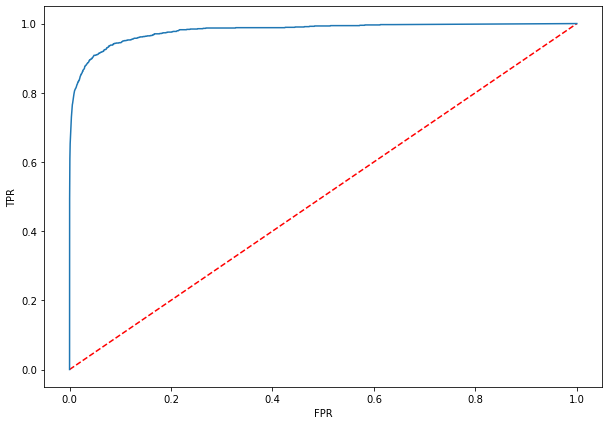

In [298]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lrModel.summary.roc.select('FPR').collect(),
         lrModel.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [241]:
# Area under precision-recall curve
areaUnderPR_LR = evaluator.evaluate(prediction_LR, {evaluator.metricName: "areaUnderPR"})
print("Area under PR = %s" % areaUnderPR_LR)

Area under PR = 0.49758127044195255


In [242]:
results = {}

In [243]:
results['Logestic Regression'] = [recall_LR, precision_LR, f1_score_LR, areaUnderROC_LR, areaUnderPR_LR]

In [244]:
results

{'Logestic Regression': [0.43253968253968256,
  0.9008264462809917,
  0.5844504021447721,
  0.9867293666404062,
  0.49758127044195255]}

# Decision Tree Classifier :

In [245]:
from pyspark.ml.classification import DecisionTreeClassifier

# Using the DecisionTree classifier model
dt = DecisionTreeClassifier(labelCol = "isFraud", featuresCol = "features", seed = 54321, maxDepth = 5)

dt_model = dt.fit(train)

In [246]:
# Make predictions.
prediction_DT = dt_model.transform(test)

In [247]:
# Select example rows to display.
prediction_DT.select('features', 'rawPrediction', 'probability', 'prediction').show(5)

+--------------------+----------------+--------------------+----------+
|            features|   rawPrediction|         probability|prediction|
+--------------------+----------------+--------------------+----------+
|[1.0,25.12,61663....|  [421037.0,0.0]|           [1.0,0.0]|       0.0|
|[1.0,527.15,72421...|  [421037.0,0.0]|           [1.0,0.0]|       0.0|
|(11,[0,1,4,5,6,7]...|[303828.0,198.0]|[0.99934873991040...|       0.0|
|[1.0,648.64,873.0...|  [421037.0,0.0]|           [1.0,0.0]|       0.0|
|[1.0,1239.06,3963...|  [421037.0,0.0]|           [1.0,0.0]|       0.0|
+--------------------+----------------+--------------------+----------+
only showing top 5 rows



In [248]:
prediction_DT.groupBy("isFraud", "prediction").count().show()

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|      1|       0.0|    80|
|      0|       0.0|200279|
|      1|       1.0|   172|
|      0|       1.0|    35|
+-------+----------+------+



In [249]:
tp = prediction_DT[(prediction_DT.isFraud == 1) & (prediction_DT.prediction == 1)].count()
tn = prediction_DT[(prediction_DT.isFraud == 0) & (prediction_DT.prediction == 0)].count()
fp = prediction_DT[(prediction_DT.isFraud == 0) & (prediction_DT.prediction == 1)].count()
fn = prediction_DT[(prediction_DT.isFraud == 1) & (prediction_DT.prediction == 0)].count()
recall_DT = tp/(tp+fn)
precision_DT = tp/(tp+fp)
f1_score_DT = 2*(recall_DT*precision_DT)/(recall_DT+precision_DT)
print("Recall : ",recall_DT)
print("Precision : ", precision_DT)
print("F1 Score : ", f1_score_DT)

Recall :  0.6825396825396826
Precision :  0.8309178743961353
F1 Score :  0.7494553376906319


In [250]:
# Area under ROC curve
areaUnderROC_DT = evaluator.evaluate(prediction_DT, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC = %s" % areaUnderROC_DT)

Area under ROC = 0.6450244841788868


In [251]:
# Area under precision-recall curve
areaUnderPR_DT = evaluator.evaluate(prediction_DT, {evaluator.metricName: "areaUnderPR"})
print("Area under PR = %s" % areaUnderPR_DT)

Area under PR = 0.0016522708555186821


In [252]:
results['Decision Tree Classifier'] = [recall_DT, precision_DT, f1_score_DT, areaUnderROC_DT, areaUnderPR_DT]
results

{'Logestic Regression': [0.43253968253968256,
  0.9008264462809917,
  0.5844504021447721,
  0.9867293666404062,
  0.49758127044195255],
 'Decision Tree Classifier': [0.6825396825396826,
  0.8309178743961353,
  0.7494553376906319,
  0.6450244841788868,
  0.0016522708555186821]}

# Random Forest Classifier :

In [253]:
from pyspark.ml.classification import RandomForestClassifier

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="isFraud", featuresCol="features", numTrees=10)

rf_model = rf.fit(train)

In [254]:
# Make predictions.
prediction_RF = rf_model.transform(test)

In [255]:
prediction_RF.groupBy("isFraud", "prediction").count().show()

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|      1|       0.0|   162|
|      0|       0.0|200314|
|      1|       1.0|    90|
+-------+----------+------+



In [256]:
tp = prediction_RF[(prediction_RF.isFraud == 1) & (prediction_RF.prediction == 1)].count()
tn = prediction_RF[(prediction_RF.isFraud == 0) & (prediction_RF.prediction == 0)].count()
fp = prediction_RF[(prediction_RF.isFraud == 0) & (prediction_RF.prediction == 1)].count()
fn = prediction_RF[(prediction_RF.isFraud == 1) & (prediction_RF.prediction == 0)].count()
recall_RF = tp/(tp+fn)
precision_RF = tp/(tp+fp)
f1_score_RF = 2*(recall_RF*precision_RF)/(recall_RF+precision_RF)
print("Recall : ",recall_RF)
print("Precision : ", precision_RF)
print("F1 Score : ", f1_score_RF)

Recall :  0.35714285714285715
Precision :  1.0
F1 Score :  0.5263157894736842


In [257]:
# Area under ROC curve
areaUnderROC_RF = evaluator.evaluate(prediction_RF, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC = %s" % areaUnderROC_RF)

Area under ROC = 0.9771278735242811


In [258]:
# Area under precision-recall curve
areaUnderPR_RF = evaluator.evaluate(prediction_RF, {evaluator.metricName: "areaUnderPR"})
print("Area under PR = %s" % areaUnderPR_RF)

Area under PR = 0.7343650239168383


In [259]:
results['Random Forest Classifier'] = [recall_RF, precision_RF, f1_score_RF, areaUnderROC_RF, areaUnderPR_RF]
results

{'Logestic Regression': [0.43253968253968256,
  0.9008264462809917,
  0.5844504021447721,
  0.9867293666404062,
  0.49758127044195255],
 'Decision Tree Classifier': [0.6825396825396826,
  0.8309178743961353,
  0.7494553376906319,
  0.6450244841788868,
  0.0016522708555186821],
 'Random Forest Classifier': [0.35714285714285715,
  1.0,
  0.5263157894736842,
  0.9771278735242811,
  0.7343650239168383]}

# Gradient-Boosted Tree Classifier

In [260]:
from pyspark.ml.classification import GBTClassifier

# Train a GBT model.
gbt = GBTClassifier(labelCol="isFraud", featuresCol="features", maxIter=10)

# Train model. 
gbt_model = gbt.fit(train)

In [261]:
# Make predictions.
prediction_GBT = gbt_model.transform(test)

In [262]:
prediction_GBT.groupBy("isFraud", "prediction").count().show()

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|      1|       0.0|    82|
|      0|       0.0|200307|
|      1|       1.0|   170|
|      0|       1.0|     7|
+-------+----------+------+



In [263]:
tp = prediction_GBT[(prediction_GBT.isFraud == 1) & (prediction_GBT.prediction == 1)].count()
tn = prediction_GBT[(prediction_GBT.isFraud == 0) & (prediction_GBT.prediction == 0)].count()
fp = prediction_GBT[(prediction_GBT.isFraud == 0) & (prediction_GBT.prediction == 1)].count()
fn = prediction_GBT[(prediction_GBT.isFraud == 1) & (prediction_GBT.prediction == 0)].count()
recall_GBT = tp/(tp+fn)
precision_GBT = tp/(tp+fp)
f1_score_GBT = 2*(recall_GBT*precision_GBT)/(recall_GBT+precision_GBT)
print("Recall : ",recall_GBT)
print("Precision : ", precision_GBT)
print("F1 Score : ", f1_score_GBT)

Recall :  0.6746031746031746
Precision :  0.96045197740113
F1 Score :  0.7925407925407926


In [264]:
# Area under ROC curve
areaUnderROC_GBT = evaluator.evaluate(prediction_GBT, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC = %s" % areaUnderROC_GBT)

Area under ROC = 0.9924144093772778


In [265]:
# Area under precision-recall curve
areaUnderPR_GBT = evaluator.evaluate(prediction_GBT, {evaluator.metricName: "areaUnderPR"})
print("Area under PR = %s" % areaUnderPR_GBT)

Area under PR = 0.7704180701161522


In [266]:
results['Gradient-Boosted Tree Classifier'] = [recall_GBT, precision_GBT, f1_score_GBT, areaUnderROC_GBT, areaUnderPR_GBT]
results

{'Logestic Regression': [0.43253968253968256,
  0.9008264462809917,
  0.5844504021447721,
  0.9867293666404062,
  0.49758127044195255],
 'Decision Tree Classifier': [0.6825396825396826,
  0.8309178743961353,
  0.7494553376906319,
  0.6450244841788868,
  0.0016522708555186821],
 'Random Forest Classifier': [0.35714285714285715,
  1.0,
  0.5263157894736842,
  0.9771278735242811,
  0.7343650239168383],
 'Gradient-Boosted Tree Classifier': [0.6746031746031746,
  0.96045197740113,
  0.7925407925407926,
  0.9924144093772778,
  0.7704180701161522]}

# Support Vector Machine : SVM 

In [272]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(labelCol="isFraud", featuresCol="features", maxIter=10, regParam=0.1)

# Train model.
lsvc_model = lsvc.fit(train)

In [273]:
# Make predictions.
prediction_LSVC = lsvc_model.transform(test)

In [274]:
prediction_LSVC.groupBy("isFraud", "prediction").count().show()

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|      1|       0.0|   252|
|      0|       0.0|200314|
+-------+----------+------+



In [276]:
tp = prediction_LSVC[(prediction_LSVC.isFraud == 1) & (prediction_LSVC.prediction == 1)].count()
tn = prediction_LSVC[(prediction_LSVC.isFraud == 0) & (prediction_LSVC.prediction == 0)].count()
fp = prediction_LSVC[(prediction_LSVC.isFraud == 0) & (prediction_LSVC.prediction == 1)].count()
fn = prediction_LSVC[(prediction_LSVC.isFraud == 1) & (prediction_LSVC.prediction == 0)].count()
recall_LSVC = tp/(tp+fn)
precision_LSVC = '--' # is not define
f1_score_LSVC = '--'
print("Recall : ",recall_LSVC)
print("Precision : ", precision_LSVC)
print("F1 Score : ", f1_score_LSVC)

Recall :  0.0
Precision :  --
F1 Score :  --


In [277]:
# Area under ROC curve
areaUnderROC_LSVC = evaluator.evaluate(prediction_LSVC, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC = %s" % areaUnderROC_LSVC)

Area under ROC = 0.41192766840187883


In [278]:
# Area under precision-recall curve
areaUnderPR_LSVC = evaluator.evaluate(prediction_LSVC, {evaluator.metricName: "areaUnderPR"})
print("Area under PR = %s" % areaUnderPR_LSVC)

Area under PR = 0.0010570132021894706


In [279]:
results['SVM'] = [recall_LSVC, precision_LSVC, f1_score_LSVC, areaUnderROC_LSVC, areaUnderPR_LSVC]
results

{'Logestic Regression': [0.43253968253968256,
  0.9008264462809917,
  0.5844504021447721,
  0.9867293666404062,
  0.49758127044195255],
 'Decision Tree Classifier': [0.6825396825396826,
  0.8309178743961353,
  0.7494553376906319,
  0.6450244841788868,
  0.0016522708555186821],
 'Random Forest Classifier': [0.35714285714285715,
  1.0,
  0.5263157894736842,
  0.9771278735242811,
  0.7343650239168383],
 'Gradient-Boosted Tree Classifier': [0.6746031746031746,
  0.96045197740113,
  0.7925407925407926,
  0.9924144093772778,
  0.7704180701161522],
 'SVM': [0.0, '--', '--', 0.41192766840187883, 0.0010570132021894706]}

# Naive Bayes

In [280]:
from pyspark.ml.classification import NaiveBayes

# create the trainer and set its parameters
nb = NaiveBayes(labelCol="isFraud", featuresCol="features", smoothing=1.0, modelType="multinomial")

# train the model
nb_model = nb.fit(train)

In [281]:
# Make predictions.
prediction_NB = nb_model.transform(test)

In [283]:
prediction_NB.groupBy("isFraud", "prediction").count().show()

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|      1|       0.0|   124|
|      0|       0.0|188675|
|      1|       1.0|   128|
|      0|       1.0| 11639|
+-------+----------+------+



In [284]:
tp = prediction_NB[(prediction_NB.isFraud == 1) & (prediction_NB.prediction == 1)].count()
tn = prediction_NB[(prediction_NB.isFraud == 0) & (prediction_NB.prediction == 0)].count()
fp = prediction_NB[(prediction_NB.isFraud == 0) & (prediction_NB.prediction == 1)].count()
fn = prediction_NB[(prediction_NB.isFraud == 1) & (prediction_NB.prediction == 0)].count()
recall_NB = tp/(tp+fn)
precision_NB = tp/(tp+fp)
f1_score_NB = 2*(recall_NB*precision_NB)/(recall_NB+precision_NB)
print("Recall : ",recall_NB)
print("Precision : ", precision_NB)
print("F1 Score : ", f1_score_NB)

Recall :  0.5079365079365079
Precision :  0.010877878813631342
F1 Score :  0.021299608952491885


In [287]:
# Area under ROC curve
areaUnderROC_NB = evaluator.evaluate(prediction_NB, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC = %s" % areaUnderROC_NB)

Area under ROC = 0.5162240916681444


In [286]:
# Area under precision-recall curve
areaUnderPR_NB = evaluator.evaluate(prediction_NB, {evaluator.metricName: "areaUnderPR"})
print("Area under PR = %s" % areaUnderPR_NB)

Area under PR = 0.0013019558389971418


In [288]:
results['Naive Bayes'] = [recall_NB, precision_NB, f1_score_NB, areaUnderROC_NB, areaUnderPR_NB]
results

{'Logestic Regression': [0.43253968253968256,
  0.9008264462809917,
  0.5844504021447721,
  0.9867293666404062,
  0.49758127044195255],
 'Decision Tree Classifier': [0.6825396825396826,
  0.8309178743961353,
  0.7494553376906319,
  0.6450244841788868,
  0.0016522708555186821],
 'Random Forest Classifier': [0.35714285714285715,
  1.0,
  0.5263157894736842,
  0.9771278735242811,
  0.7343650239168383],
 'Gradient-Boosted Tree Classifier': [0.6746031746031746,
  0.96045197740113,
  0.7925407925407926,
  0.9924144093772778,
  0.7704180701161522],
 'SVM': [0.0, '--', '--', 0.41192766840187883, 0.0010570132021894706],
 'Naive Bayes': [0.5079365079365079,
  0.010877878813631342,
  0.021299608952491885,
  0.5162240916681444,
  0.0013019558389971418]}

In [289]:
results = pd.DataFrame.from_dict(results, orient='index',
                       columns=['Recall', 'Precision', 'F1 Score', 'Area Under ROC', 'Area Under PR'])

In [291]:
results

,Recall,Precision,F1 Score,Area Under ROC,Area Under PR
Logestic Regression,0.432540,0.900826,0.58445,0.986729,0.497581
Decision Tree Classifier,0.682540,0.830918,0.749455,0.645024,0.001652
Random Forest Classifier,0.357143,1,0.526316,0.977128,0.734365
Gradient-Boosted Tree Classifier,0.674603,0.960452,0.792541,0.992414,0.770418
SVM,0.000000,--,--,0.411928,0.001057
Naive Bayes,0.507937,0.0108779,0.0212996,0.516224,0.001302
